# Imports

In [21]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import re
import json
import os
import glob
import gzip
from multiprocessing import Pool, cpu_count
from typing import Tuple
from tqdm import tqdm
from textblob import TextBlob

# How has Russian equipment  and Personnel losses changed over time?

# Equipment

In [2]:
russian_equip = pd.read_csv('russia_losses_equipment.csv')
russian_pers = pd.read_csv('russia_losses_personnel.csv')
russian_equip.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 655 entries, 0 to 654
Data columns (total 19 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   date                       655 non-null    object 
 1   day                        655 non-null    int64  
 2   aircraft                   655 non-null    int64  
 3   helicopter                 655 non-null    int64  
 4   tank                       655 non-null    int64  
 5   APC                        655 non-null    int64  
 6   field artillery            655 non-null    int64  
 7   MRL                        655 non-null    int64  
 8   military auto              65 non-null     float64
 9   fuel tank                  65 non-null     float64
 10  drone                      655 non-null    int64  
 11  naval ship                 655 non-null    int64  
 12  anti-aircraft warfare      655 non-null    int64  
 13  special equipment          636 non-null    float64

In [3]:
equip_df = russian_equip.fillna(0)
equip_df.drop(columns=['greatest losses direction', 'day'],inplace = True)

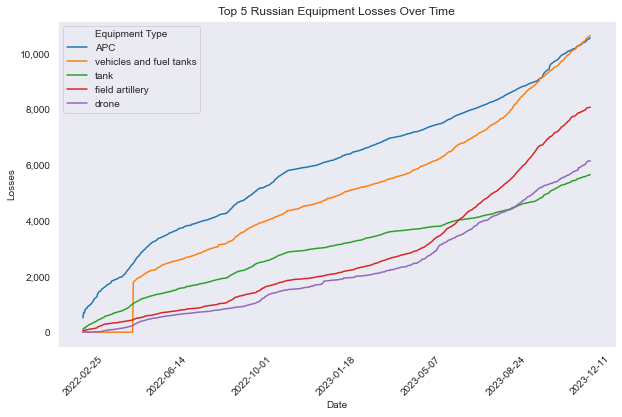

In [4]:
# Calculate the sum of values for each column
sum_values = equip_df.iloc[:, 1:].sum(axis=0)

# Select the top 5 columns with the highest sum values
top_columns = sum_values.nlargest(5).index.tolist()

# Subset the DataFrame to include only the top 5 columns
df_top5 = equip_df[['date'] + top_columns]

# Melt the DataFrame to long format for Seaborn
df_long = pd.melt(df_top5, id_vars=['date'], var_name='Variable', value_name='Value')

# Create a time series plot using Seaborn
sns.set_style("dark")
plt.figure(figsize=(10, 6))
sns.lineplot(x='date', y='Value', hue='Variable', data=df_long)

# Optionally, you can add labels and a legend
plt.title('Top 5 Russian Equipment Losses Over Time')
plt.xlabel('Date')
plt.ylabel('Losses')
plt.legend(title='Equipment Type')

xtick_positions = [df_top5['date'].iloc[i] for i in range(0, len(df_top5['date']), len(df_top5['date']) // 6)]
plt.xticks(xtick_positions, rotation=45)  # Adjust rotation as needed

def format_with_commas(value, _):
    return f'{int(value):,}'

# Apply the custom formatting function to the y-axis ticks
plt.gca().get_yaxis().set_major_formatter(FuncFormatter(format_with_commas))


plt.show()

# Figure Explanation

The above plot shows the losses of the top five most used equipment by the Russian army. Across all these equipments, Russia has been reporting increases in losses consitently since Feburary of 2022. The most used piece of equipment are APC's (Amphibous Personel Carriers) which are basically armored vehicles with a turret mainly used to transport troops in high danger areas.

# Trends

Analyzing trends of different equipments, we can see that since the beginning of 2022, APC's and Tanks are following a logorithmic growth, meaning they are growing but the rate of growth is not necessarily increasing. These types of trends usually lead to some kind of plateau. In contrast, Vehicles and fuel tanks, field artillery and drones all are seeing exponential growths. Meaning that the rate of losses for these equipments is increasing.

# So what?

After analyzing this figure, we have multiple possible avenues of insight. Firstly, We can make the assumption that since the beginning of the war, Russia has increased their deployment of equipment into this war. After all, no equipment could see an increase in losses without a larger supply of equipment to lose. The second and more strategic insight, is that the Ukrainian Army has been progressivley getting better at destroying russian equipment. Just because the supply of equipment increases, doesn't necessarily mean that their has to be an increase in losses. For example, the Russian army could have potentially overwhelmed the Ukrainina army and forced surrender in battles, but based on the data, we can assume that this was not the case. All in all, this figure reports positive insight for the Ukrainians and negative for the Russians.

# Personnel

In [5]:
russian_pers.drop(columns='personnel*', inplace=True)

In [6]:
russian_pers = russian_pers.fillna(0)
russian_pers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 655 entries, 0 to 654
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   date       655 non-null    object 
 1   day        655 non-null    int64  
 2   personnel  655 non-null    int64  
 3   POW        655 non-null    float64
dtypes: float64(1), int64(2), object(1)
memory usage: 20.6+ KB


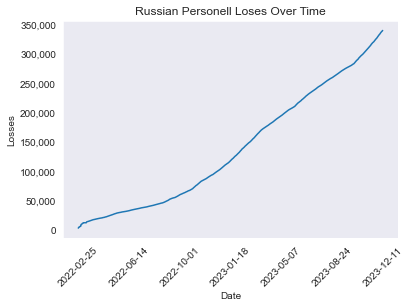

In [7]:
sns.lineplot(data=russian_pers, x='date', y='personnel')

xtick_positions = [russian_pers['date'].iloc[i] for i in range(0, len(russian_pers['date']), len(russian_pers['date']) // 6)]
plt.xticks(xtick_positions, rotation=45)  # Adjust rotation as needed

sns.set_style('darkgrid')
plt.title('Russian Personell Loses Over Time')
plt.xlabel('Date')
plt.ylabel('Losses')

def format_with_commas(value, _):
    return f'{int(value):,}'

# Apply the custom formatting function to the y-axis ticks
plt.gca().get_yaxis().set_major_formatter(FuncFormatter(format_with_commas))


plt.show();

# Figure explanation

This figure shows the losses of Russian personell over time. The increase of personell lost appears to be following a slight exponential trend since Feburary 2022. This is very upsetting to see. After this graph printed in my notebook I was frozen for a few minutes. These numbers are so sad to see, all the families and friends that are losing someone in this war. Rest in Peace to all of those involved in this war of nonsense.

# Statistics

In [8]:
print('Russian Personnel loss totals are:',russian_pers.tail(1)['personnel'].values[0])
print('Russian Prisoner of War totals are:',russian_pers['POW'].max())

Russian Personnel loss totals are: 339850
Russian Prisoner of War totals are: 496.0


# Sentiment Analysis on Tweets about the Ukraine War around the World

### The pre-processing part of this twitter data was from a public notebook linked [here](https://www.kaggle.com/code/esterinkojtari/bakhmut-sentiment-analysis)

In [9]:
# Load the data
all_files = []
for dirname, _, filenames in os.walk('/Users/Max/Downloads/Python for DS/Final Project/archive (2)'):
    for filename in filenames:
        full_path=os.path.join(dirname, filename)
        all_files.append(full_path)

In [10]:
paths = []
for dirname, _, filenames in os.walk('/Users/Max/Downloads/Python for DS/Final Project/archive (2)'):
    for filename in filenames:
        paths.append(os.path.join(dirname, filename))

In [11]:
# sort the files
all_files.sort()

In [14]:
files = [file for file in all_files if re.search(r'((2023(0[1-9]|1[0-2])(0[1-9]|[12][0-9]|3[01])))', file)]

In [15]:
# Reading and Concatenating Multiple Compressed CSV Files into a Single DataFrame
tmp_df_list = []
for file in files:
    # unzip and read in the csv file as a dataframe
    tmp_df = pd.read_csv(file, compression="gzip", header=0, index_col=0)
    # append dataframe to temp list
    tmp_df_list.append(tmp_df)

# concatenate the dataframes in the temp list row-wise
data = pd.concat(tmp_df_list, axis=0)

Reading in /Users/Max/Downloads/Python for DS/Final Project/archive (2)\20230101_UkraineCombinedTweetsDeduped.csv.gzip
Reading in /Users/Max/Downloads/Python for DS/Final Project/archive (2)\20230102_UkraineCombinedTweetsDeduped.csv.gzip
Reading in /Users/Max/Downloads/Python for DS/Final Project/archive (2)\20230103_UkraineCombinedTweetsDeduped.csv.gzip
Reading in /Users/Max/Downloads/Python for DS/Final Project/archive (2)\20230104_UkraineCombinedTweetsDeduped.csv.gzip
Reading in /Users/Max/Downloads/Python for DS/Final Project/archive (2)\20230105_UkraineCombinedTweetsDeduped.csv.gzip
Reading in /Users/Max/Downloads/Python for DS/Final Project/archive (2)\20230106_UkraineCombinedTweetsDeduped.csv.gzip
Reading in /Users/Max/Downloads/Python for DS/Final Project/archive (2)\20230107_UkraineCombinedTweetsDeduped.csv.gzip
Reading in /Users/Max/Downloads/Python for DS/Final Project/archive (2)\20230108_UkraineCombinedTweetsDeduped.csv.gzip
Reading in /Users/Max/Downloads/Python for DS/Fi

C:\Users\Max\AppData\Local\Temp/ipykernel_20720/4025912818.py:6: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  tmp_df = pd.read_csv(file, compression="gzip", header=0, index_col=0)


Reading in /Users/Max/Downloads/Python for DS/Final Project/archive (2)\20230301_UkraineCombinedTweetsDeduped.csv.gzip
Reading in /Users/Max/Downloads/Python for DS/Final Project/archive (2)\20230302_UkraineCombinedTweetsDeduped.csv.gzip
Reading in /Users/Max/Downloads/Python for DS/Final Project/archive (2)\20230303_UkraineCombinedTweetsDeduped.csv.gzip
Reading in /Users/Max/Downloads/Python for DS/Final Project/archive (2)\20230304_UkraineCombinedTweetsDeduped.csv.gzip
Reading in /Users/Max/Downloads/Python for DS/Final Project/archive (2)\20230305_UkraineCombinedTweetsDeduped.csv.gzip
Reading in /Users/Max/Downloads/Python for DS/Final Project/archive (2)\20230306_UkraineCombinedTweetsDeduped.csv.gzip
Reading in /Users/Max/Downloads/Python for DS/Final Project/archive (2)\20230307_UkraineCombinedTweetsDeduped.csv.gzip
Reading in /Users/Max/Downloads/Python for DS/Final Project/archive (2)\20230308_UkraineCombinedTweetsDeduped.csv.gzip
Reading in /Users/Max/Downloads/Python for DS/Fi

C:\Users\Max\AppData\Local\Temp/ipykernel_20720/4025912818.py:6: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  tmp_df = pd.read_csv(file, compression="gzip", header=0, index_col=0)


Reading in /Users/Max/Downloads/Python for DS/Final Project/archive (2)\20230402_UkraineCombinedTweetsDeduped.csv.gzip
Reading in /Users/Max/Downloads/Python for DS/Final Project/archive (2)\20230403_UkraineCombinedTweetsDeduped.csv.gzip
Reading in /Users/Max/Downloads/Python for DS/Final Project/archive (2)\20230404_UkraineCombinedTweetsDeduped.csv.gzip
Reading in /Users/Max/Downloads/Python for DS/Final Project/archive (2)\20230405_UkraineCombinedTweetsDeduped.csv.gzip
Reading in /Users/Max/Downloads/Python for DS/Final Project/archive (2)\20230406_UkraineCombinedTweetsDeduped.csv.gzip
Reading in /Users/Max/Downloads/Python for DS/Final Project/archive (2)\20230407_UkraineCombinedTweetsDeduped.csv.gzip
Reading in /Users/Max/Downloads/Python for DS/Final Project/archive (2)\20230408_UkraineCombinedTweetsDeduped.csv.gzip
Reading in /Users/Max/Downloads/Python for DS/Final Project/archive (2)\20230409_UkraineCombinedTweetsDeduped.csv.gzip
Reading in /Users/Max/Downloads/Python for DS/Fi

C:\Users\Max\AppData\Local\Temp/ipykernel_20720/4025912818.py:6: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  tmp_df = pd.read_csv(file, compression="gzip", header=0, index_col=0)


Reading in /Users/Max/Downloads/Python for DS/Final Project/archive (2)\20230510_UkraineCombinedTweetsDeduped.csv.gzip
Reading in /Users/Max/Downloads/Python for DS/Final Project/archive (2)\20230511_to_20230512_UkraineCombinedTweetsDeduped.csv.gzip
Reading in /Users/Max/Downloads/Python for DS/Final Project/archive (2)\20230513_UkraineCombinedTweetsDeduped.csv.gzip
Reading in /Users/Max/Downloads/Python for DS/Final Project/archive (2)\20230514_UkraineCombinedTweetsDeduped.csv.gzip
Reading in /Users/Max/Downloads/Python for DS/Final Project/archive (2)\20230515_to_20230516_UkraineCombinedTweetsDeduped.csv.gzip
Reading in /Users/Max/Downloads/Python for DS/Final Project/archive (2)\20230517_UkraineCombinedTweetsDeduped.csv.gzip
Reading in /Users/Max/Downloads/Python for DS/Final Project/archive (2)\20230518_to_20230520_UkraineCombinedTweetsDeduped.csv.gzip


C:\Users\Max\AppData\Local\Temp/ipykernel_20720/4025912818.py:6: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  tmp_df = pd.read_csv(file, compression="gzip", header=0, index_col=0)


Reading in /Users/Max/Downloads/Python for DS/Final Project/archive (2)\20230521_UkraineCombinedTweetsDeduped.csv.gzip
Reading in /Users/Max/Downloads/Python for DS/Final Project/archive (2)\20230522_UkraineCombinedTweetsDeduped.csv.gzip
Reading in /Users/Max/Downloads/Python for DS/Final Project/archive (2)\20230523_UkraineCombinedTweetsDeduped.csv.gzip
Reading in /Users/Max/Downloads/Python for DS/Final Project/archive (2)\20230524_UkraineCombinedTweetsDeduped.csv.gzip
Reading in /Users/Max/Downloads/Python for DS/Final Project/archive (2)\20230525_UkraineCombinedTweetsDeduped.csv.gzip
Reading in /Users/Max/Downloads/Python for DS/Final Project/archive (2)\20230526_UkraineCombinedTweetsDeduped.csv.gzip
Reading in /Users/Max/Downloads/Python for DS/Final Project/archive (2)\20230527_UkraineCombinedTweetsDeduped.csv.gzip
Reading in /Users/Max/Downloads/Python for DS/Final Project/archive (2)\20230528_UkraineCombinedTweetsDeduped.csv.gzip
Reading in /Users/Max/Downloads/Python for DS/Fi

In [17]:
data.head()

,userid,username,acctdesc,location,following,followers,totaltweets,usercreatedts,tweetid,tweetcreatedts,...,original_tweet_userid,original_tweet_username,in_reply_to_status_id,in_reply_to_user_id,in_reply_to_screen_name,is_quote_status,quoted_status_id,quoted_status_userid,quoted_status_username,extractedts
58360,2852858199,interdamazonia,O olhar dos Internacionalistas Amazônidas para...,"Belém, PA - Brasil",475,699,10778,2014-10-31 02:40:20,1609338614646771714,2023-01-01 00:00:00,...,0,NaN,0,0,NaN,False,0,0,NaN,2023-01-01 13:36:05.605290
58361,1575330860181880832,eldoggo75710233,#NAFO fellephant armed with a fophana fophaser...,#NAFO base on moon's dark side,160,51,39,2022-09-29 03:47:08,1609338615011893249,2023-01-01 00:00:00,...,0,NaN,0,0,NaN,True,1609326009249140736,1505481949854502912,Gerashchenko_en,2023-01-01 10:06:26.383363
58362,805486618077315072,christoalnz,"Natural Health Therapist, Global Warming belie...","Auckland, New Zealand",2080,1203,14862,2016-12-04 18:59:09,1609338623010406401,2023-01-01 00:00:02,...,0,NaN,1609179578286866432,3306657923,RusMission_EU,False,0,0,NaN,2023-01-01 11:05:54.713751
58363,6135622,dw_espanol,Desde Alemania para el mundo. Aquí y ahora. Se...,"Berlin, Germany",163,1320640,163976,2007-05-18 11:40:24,1609338623639359491,2023-01-01 00:00:02,...,0,NaN,0,0,NaN,False,0,0,NaN,2023-01-01 17:36:29.161601
58364,1499763123603050497,FuckPutinBot,"I'm a bot. Every minute of every day, I tell P...",NaN,14,286,423555,2022-03-04 15:06:25,1609338625417789443,2023-01-01 00:00:03,...,0,NaN,0,0,NaN,False,0,0,NaN,2023-01-01 20:51:51.246061


In [19]:
# Converting date/time columns to datetime format and checking data types
data["usercreatedts"] = pd.to_datetime(data["usercreatedts"])
data["tweetcreatedts"] = pd.to_datetime(data["tweetcreatedts"])
data["extractedts"] = pd.to_datetime(data["extractedts"])

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13141766 entries, 58360 to 310874
Data columns (total 28 columns):
 #   Column                   Dtype         
---  ------                   -----         
 0   userid                   int64         
 1   username                 object        
 2   acctdesc                 object        
 3   location                 object        
 4   following                int64         
 5   followers                int64         
 6   totaltweets              int64         
 7   usercreatedts            datetime64[ns]
 8   tweetid                  int64         
 9   tweetcreatedts           datetime64[ns]
 10  retweetcount             int64         
 11  text                     object        
 12  hashtags                 object        
 13  language                 object        
 14  coordinates              object        
 15  favorite_count           int64         
 16  is_retweet               bool          
 17  original_tweet_id      

In [23]:
# drop rows with missing values in the 'text' column since we can't compute a sentiment with them
data = data.dropna(subset=['text'])

# Filter tweets containing the keyword "Kyiv" with regex
kyiv_tweets = data[data['text'].str.contains(r'Kyiv|Київ|Киев', na=False)]

In [25]:
# Define a function to perform sentiment analysis on a text using TextBlob
def get_sentiment(text):
    blob = TextBlob(text)
    return blob.sentiment.polarity

# Apply sentiment analysis to the filtered tweets
kyiv_tweets['sentiment'] = kyiv_tweets['text'].apply(get_sentiment)

Average sentiment score of Bakhmut tweets: -0.0074325972323142035


C:\Users\Max\AppData\Local\Temp/ipykernel_20720/1850975773.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kyiv_tweets['sentiment'] = kyiv_tweets['text'].apply(get_sentiment)


In [26]:
# Filter the tweets by language
df_en = kyiv_tweets[kyiv_tweets['language'] == 'en']
df_ru = kyiv_tweets[kyiv_tweets['language'] == 'ru']
df_uk = kyiv_tweets[kyiv_tweets['language'] == 'uk']

df_en.to_csv('kyiv_tweets_en.csv', index=False)
df_ru.to_csv('kyiv_tweets_ru.csv', index=False)
df_uk.to_csv('kyiv_tweets_uk.csv', index=False)

# Define a function to get the sentiment of a tweet
def get_sentiment(tweet):
    blob = TextBlob(tweet)
    return blob.sentiment.polarity

# Get the sentiment for each tweet in each language we filtered for
df_en['sentiment'] = df_en['text'].apply(get_sentiment)
df_ru['sentiment'] = df_ru['text'].apply(get_sentiment)
df_uk['sentiment'] = df_uk['text'].apply(get_sentiment)

# Group the tweets by date and get the mean sentiment for each date
en_sentiment = df_en.groupby(pd.to_datetime(df_en['tweetcreatedts']).dt.date)['sentiment'].mean()
ru_sentiment = df_ru.groupby(pd.to_datetime(df_ru['tweetcreatedts']).dt.date)['sentiment'].mean()
uk_sentiment = df_uk.groupby(pd.to_datetime(df_uk['tweetcreatedts']).dt.date)['sentiment'].mean()

C:\Users\Max\AppData\Local\Temp/ipykernel_20720/12418483.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_en['sentiment'] = df_en['text'].apply(get_sentiment)
C:\Users\Max\AppData\Local\Temp/ipykernel_20720/12418483.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ru['sentiment'] = df_ru['text'].apply(get_sentiment)
C:\Users\Max\AppData\Local\Temp/ipykernel_20720/12418483.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_index

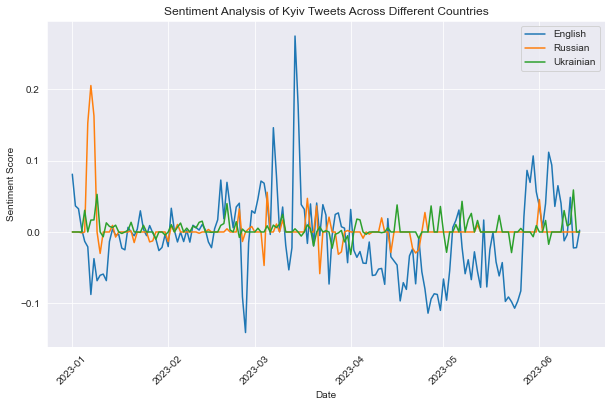

In [35]:
# Plot sentiment scores over time
plt.figure(figsize=(10,6))
plt.plot(en_sentiment.index, en_sentiment.values, label='English')
plt.plot(ru_sentiment.index, ru_sentiment.values, label='Russian')
plt.plot(uk_sentiment.index, uk_sentiment.values, label='Ukrainian')

plt.title('Sentiment Analysis of Kyiv Tweets Across Different Countries')
plt.xlabel('Date')
plt.ylabel('Sentiment Score')
plt.legend()
plt.xticks(rotation=45)

plt.show()

# Figure Explanation

The figure above is a line plot showing the change in sentiment score of tweets containing the word "Kyiv", the capitol of Ukraine. The figure has three seperate lines that represent three different languages from the tweet which are English, Russian and Ukrainian. One thing to note is that a decent number of Ukranian civilians living on the eastern front actually speak Russian.

# Analyzing Spikes and Dips

The first big spike in this figure is a Russian tweet sentiment spike in janurary 2023.

Here are some events that happened in Kyiv in January 2023: 
- New Year's Day: Explosions in Kyiv on New Year's Day kill four people and wound many more
- January 2, 2023: Russian drones attack infrastructure in Kyiv, damaging energy facilities and causing power outages
- January 23, 2023: Russia launches missiles and drones at Kyiv, killing at least 11 people
- January 26, 2023: Russia launches 55 missiles at Kyiv, including air and sea-based missiles
- January 7, 2023: Russia launches attacks across Ukraine, killing at least two civilians, in violation of a self-declared ceasefire

Russia put a lot of pressure on Ukraine in Janurary and the Russian sentiment over these attacks seemed to be positive.

The first big dip in this figure is in english tweets in late feburary. This time period marked the one year anniversary of when the war started. It is likely that this reminded people of how long this war has been raging on and brought sorrow feelings to english speakers a like that had to watch as so many people die.

The next big spike in the data is in March 2023, once again from the english speakers. Around this time, Russia launched a country wide barage of missle and drone strikes against multiple cities in Ukraine. This was an inhumane attack by the russians that led to so many civilian deaths and destruction of infrastructure and this attack really shifted a tone amongst the world in regards to supporting Ukraine. It is likely that the increase is sentiment score in this time period is from words of encouragement and support towards Kyiv, one of the cities affected by this attack.

After this period their are no major spikes or dips, but their is a steady decrease in sentiment among english until June. This is likely due to the dislike of how America was giving so much money to Ukraine during this time. With all the issues going on the U.S., citizens likely felt like their taxes should be spent more internally rather than internationally.

# Statistics

In [41]:
print("Average sentiment score of English tweets:", en_sentiment.mean())
print("Average sentiment score of Ukrainian tweets:", uk_sentiment.mean())
print("Average sentiment score of Russian tweets:", ru_sentiment.mean())

Average sentiment score of English tweets: -0.00866654949977672
Average sentiment score of Ukrainian tweets: 0.003815393431503507
Average sentiment score of Russian tweets: 0.0030602195795483927
